# **Importing libraries**

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# **Load Dataset**

In [34]:
data = pd.read_csv('/content/time_series_covid19_confirmed_global.csv')

# **Display first few rows**

In [35]:
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


# **Data preprocessing**

**Dropping unnecessary columns**

In [36]:
data = data.drop(columns=['Province/State'])

**Fill missing values with 0**


In [37]:
data = data.fillna(0)

**Transpose the data to have dates as rows and countries/regions as columns**

In [38]:
data_transposed = data.set_index(['Country/Region', 'Lat', 'Long']).T

**Convert index to datetime**

In [39]:
data_transposed.index = pd.to_datetime(data_transposed.index)

<ipython-input-39-91a9a9eb9ab0>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_transposed.index = pd.to_datetime(data_transposed.index)


**Feature Engineering: Adding rolling average and lag features**

In [40]:
data_transposed_rolling = data_transposed.rolling(window=7).mean().fillna(0)
data_transposed_diff = data_transposed.diff().fillna(0)
data_transposed_combined = pd.concat([data_transposed, data_transposed_rolling, data_transposed_diff], axis=1)
data_transposed_combined.columns = [f"{col}_{suffix}" for col in data_transposed.columns for suffix in ["original", "rolling", "diff"]]

In [41]:
imputer = SimpleImputer(strategy='mean')
data_transposed_combined_imputed = pd.DataFrame(imputer.fit_transform(data_transposed_combined), columns=data_transposed_combined.columns)

**Creating supervised learning data**

In [42]:
look_back = 3
X, y = [], []
for i in range(len(data_transposed_combined) - look_back):
    X.append(data_transposed_combined.iloc[i:i + look_back].values.flatten())
    y.append(data_transposed.iloc[i + look_back].values)

X, y = np.array(X), np.array(y)

# **Split the data into training and testing sets**

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **hyperparameters for RandomForestRegressor**




In [44]:
best_model = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=150, random_state=42)

# **Train the decision tree regressor**

**Predict on the test set**

In [45]:
y_pred = best_model.predict(X_test)

# **Evaluate the model**


In [46]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



In [47]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 121905121.367204
R^2 Score: 0.9994425732502794


# **Predict future cases (next 30 day)**

In [48]:
future_days = 30
last_days_data = data_transposed_combined_imputed.iloc[-look_back:].values.flatten().reshape(1, -1)
future_predictions = []
for _ in range(future_days):
    next_day_prediction = best_model.predict(last_days_data)
    future_predictions.append(next_day_prediction.flatten())
    last_days_data = np.roll(last_days_data, -data_transposed_combined_imputed.shape[1])
    last_days_data[0, -data_transposed_combined_imputed.shape[1]:] = np.concatenate([next_day_prediction.flatten(),
                                                                             next_day_prediction.flatten(),
                                                                             next_day_prediction.flatten()])


**Convert predictions to DataFrame**

In [49]:
future_predictions_df = pd.DataFrame(future_predictions, columns=data_transposed.columns)


**Print future predictions**

In [50]:
print("Future Predictions:")
print(future_predictions_df)

Future Predictions:
Country/Region    Afghanistan        Albania        Algeria       Andorra  \
Lat                 33.939110      41.153300      28.033900     42.506300   
Long               67.709953      20.168300      1.659600      1.521800     
0               209404.463460  334426.301587  271479.149437  47878.093595   
1               209404.664794  334426.350532  271479.314325  47878.192762   
2               209404.664794  334426.350532  271479.314325  47878.192762   
3               209404.192413  334426.250341  271479.162135  47878.132762   
4               209404.192413  334426.250341  271479.162135  47878.132762   
5               209404.192413  334426.250341  271479.162135  47878.132762   
6               209404.192413  334426.250341  271479.162135  47878.132762   
7               209404.192413  334426.250341  271479.162135  47878.132762   
8               209404.192413  334426.250341  271479.162135  47878.132762   
9               209404.192413  334426.250341  271479.162

# **Visualization**

**Sample a subset of the test data for better visualization**

In [51]:
sample_size = 100
indices = np.random.choice(len(y_test), sample_size, replace=False)
y_test_sample = y_test[indices]
y_pred_sample = y_pred[indices]

**Plot the actual vs predicted for the test set**

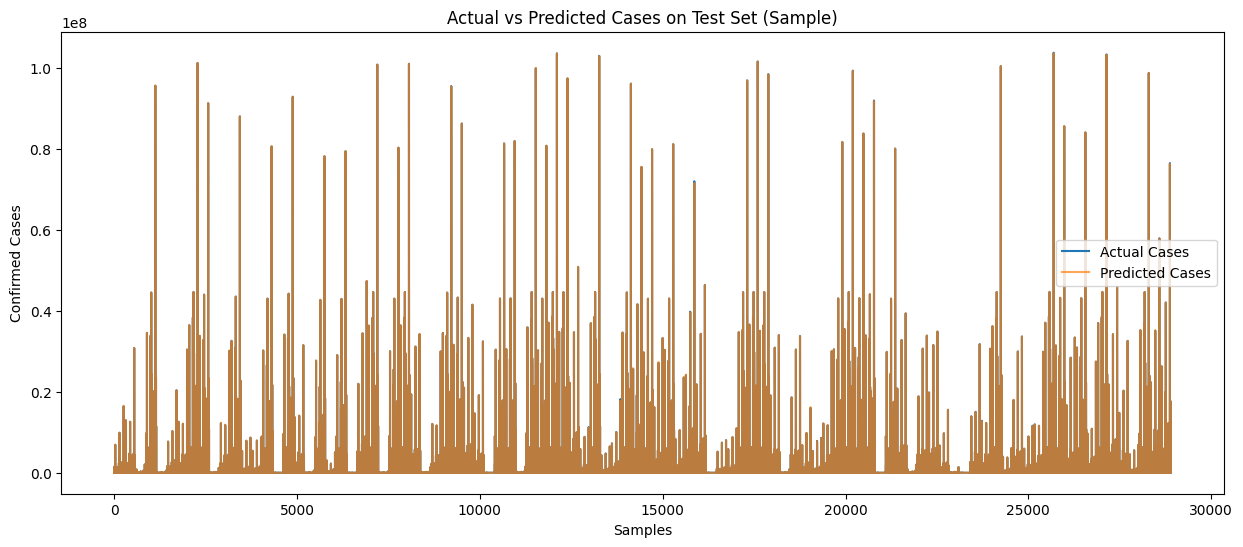

In [52]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_sample.flatten(), label='Actual Cases')
plt.plot(y_pred_sample.flatten(), label='Predicted Cases', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Confirmed Cases')
plt.title('Actual vs Predicted Cases on Test Set (Sample)')
plt.legend()
plt.show()

 **Plot the actual vs predicted for the last country**

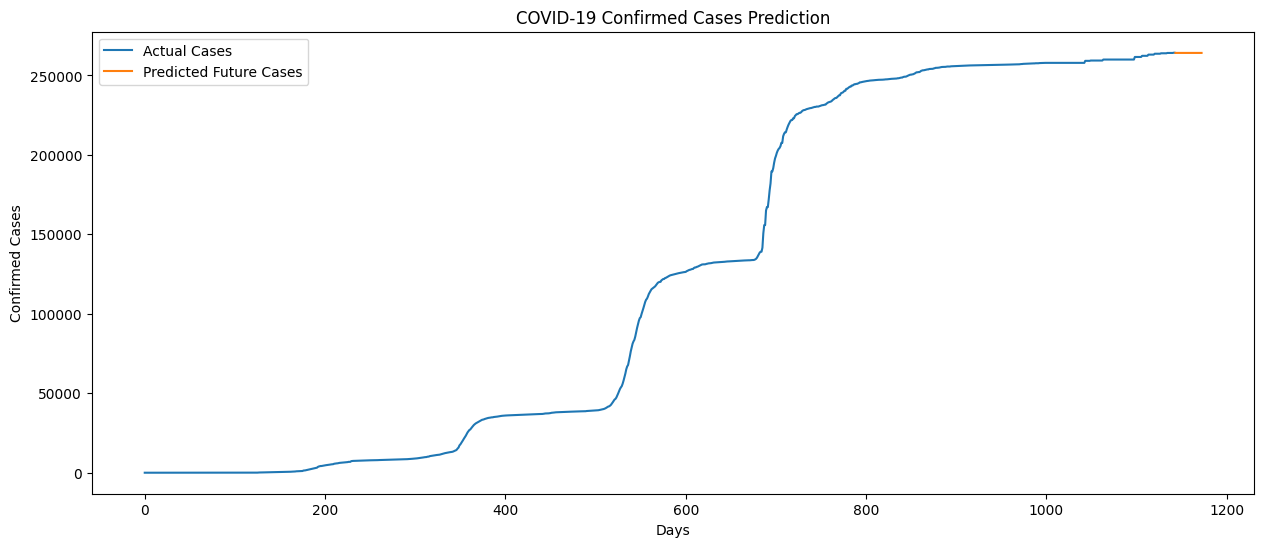

In [53]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(data_transposed)), data_transposed.iloc[:, -1], label='Actual Cases')
plt.plot(range(len(data_transposed), len(data_transposed) + future_days), future_predictions_df.iloc[:, -1], label='Predicted Future Cases')
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Confirmed Cases Prediction')
plt.legend()
plt.show()